# Table of Content <a class="anchor" id="content"></a>
- [Imports](#Imports)
- [Data Read-in](#data)
- [Build Model](#Build-Model)
- [Predicition](#prediction)

# Imports<a class="anchor" id="Imports"></a>
[back to top](#content)

In [2]:
import bambi.backend.links
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import multivariate_normal, wishart
from bambi import Model, Prior
import pymc3 as pm
import pickle

# Data Read-in <a class="anchor" id="data"></a>
[back to top](#content)

In [17]:
root = "../data/"
# load clean data without NA values
surNoNA = (pd.read_csv(root+"survCleanWithSameCols.csv", index_col=0).sort_values(["year", "sitecode"])
              .drop(['race7', 'stheight', 'stweight', 'qnobese'], axis=1))
print('The shape of the dataset without NAs has {:,} rows,{} columns'.format(surNoNA.shape[0],surNoNA.shape[1]))

The shape of the dataset without NAs has 108,151 rows,15 columns


In [14]:
# split data
train_data = surNoNA.query("year == 2011 | year == 2013 | year == 2015")
test_data = surNoNA.query("year == 2019")
train_data.carRiskScore.describe()

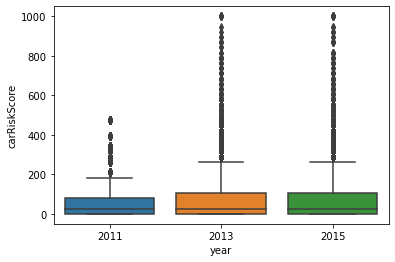

In [19]:
# plot Boxplot to see the distribution
_ = sns.boxplot(x = train_data['year'], y = train_data['carRiskScore'])

# Build group specific model Model <a class="anchor" id="Build-Model"></a>
[back to top](#content)

In [42]:
seed = 551
percent98 = surNoNA.carRiskScore.quantile(.98)
dat = surNoNA.query("carRiskScore < @percent98 & year < 2017").sample(1000, random_state = seed)
dat.loc[:,"carRiskScore"] = dat["carRiskScore"] + 1
county_idxs, counties = pd.factorize(dat["sitecode"]) # transform to numerical values
year_idxs, years = pd.factorize(dat["year"])
coords = {
    "county": counties,
    "years":years,
    "obs_id": np.arange(len(county_idxs))
}

In [50]:
num_group = len(counties)
# X_train = dat.drop(['carRiskScore'], axis = 1)
# test on toy model on two variables 'bmi' and 'age'
train = dat[['age','year','sitecode','carRiskScore', 'bmi']]
train['sitecode'] = county_idxs
train.head()

<ipython-input-50-86c7ad2d9199>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['sitecode'] = county_idxs


,age,year,sitecode,carRiskScore,bmi
292471,4.0,2011,0,79.947368,19.633715
141316,7.0,2005,1,27.315789,22.113573
310164,3.0,2013,2,132.578947,19.757606
123326,4.0,2005,3,1.000000,25.490114
263908,5.0,2011,4,1.000000,24.545265


In [51]:
# set up bambi prior
grp_mean = Prior("Normal",mu = 10, sigma = 10)
grp_sd = Prior("HalfCauchy", beta= 5)
default_prior = Prior("Normal", mu=grp_mean, sigma=grp_sd)
priors = {
    "Intercept": Prior("Normal", mu = train.carRiskScore.mean(), sigma = train.carRiskScore.std()),
    "bmi": Prior("Normal", mu = train.bmi.mean(), sigma = train.bmi.std()),
    "age": Prior("Normal", mu = train.age.mean(), sigma = train.age.std()),
    "age|year": default_prior,
    "age|sitecode": default_prior,
    "bmi|year": default_prior,
    "bmi|sitecode": default_prior
}
# fit model
model = Model(
    "carRiskScore ~  bmi + age + (age|sitecode) + (bmi|year) + (age|year) + (bmi|sitecode)",
    train,
    priors=priors
)
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [carRiskScore_sigma, bmi|sitecode_offset, bmi|sitecode_sigma, bmi|sitecode_mu, age|year_offset, age|year_sigma, age|year_mu, bmi|year_offset, bmi|year_sigma, bmi|year_mu, 1|year_offset, 1|year_sigma, age|sitecode_offset, age|sitecode_sigma, age|sitecode_mu, 1|sitecode_offset, 1|sitecode_sigma, age, bmi, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 178 seconds.
There were 60 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6939998319696511, but should be close to 0.8. Try to increase the number of tuning steps.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


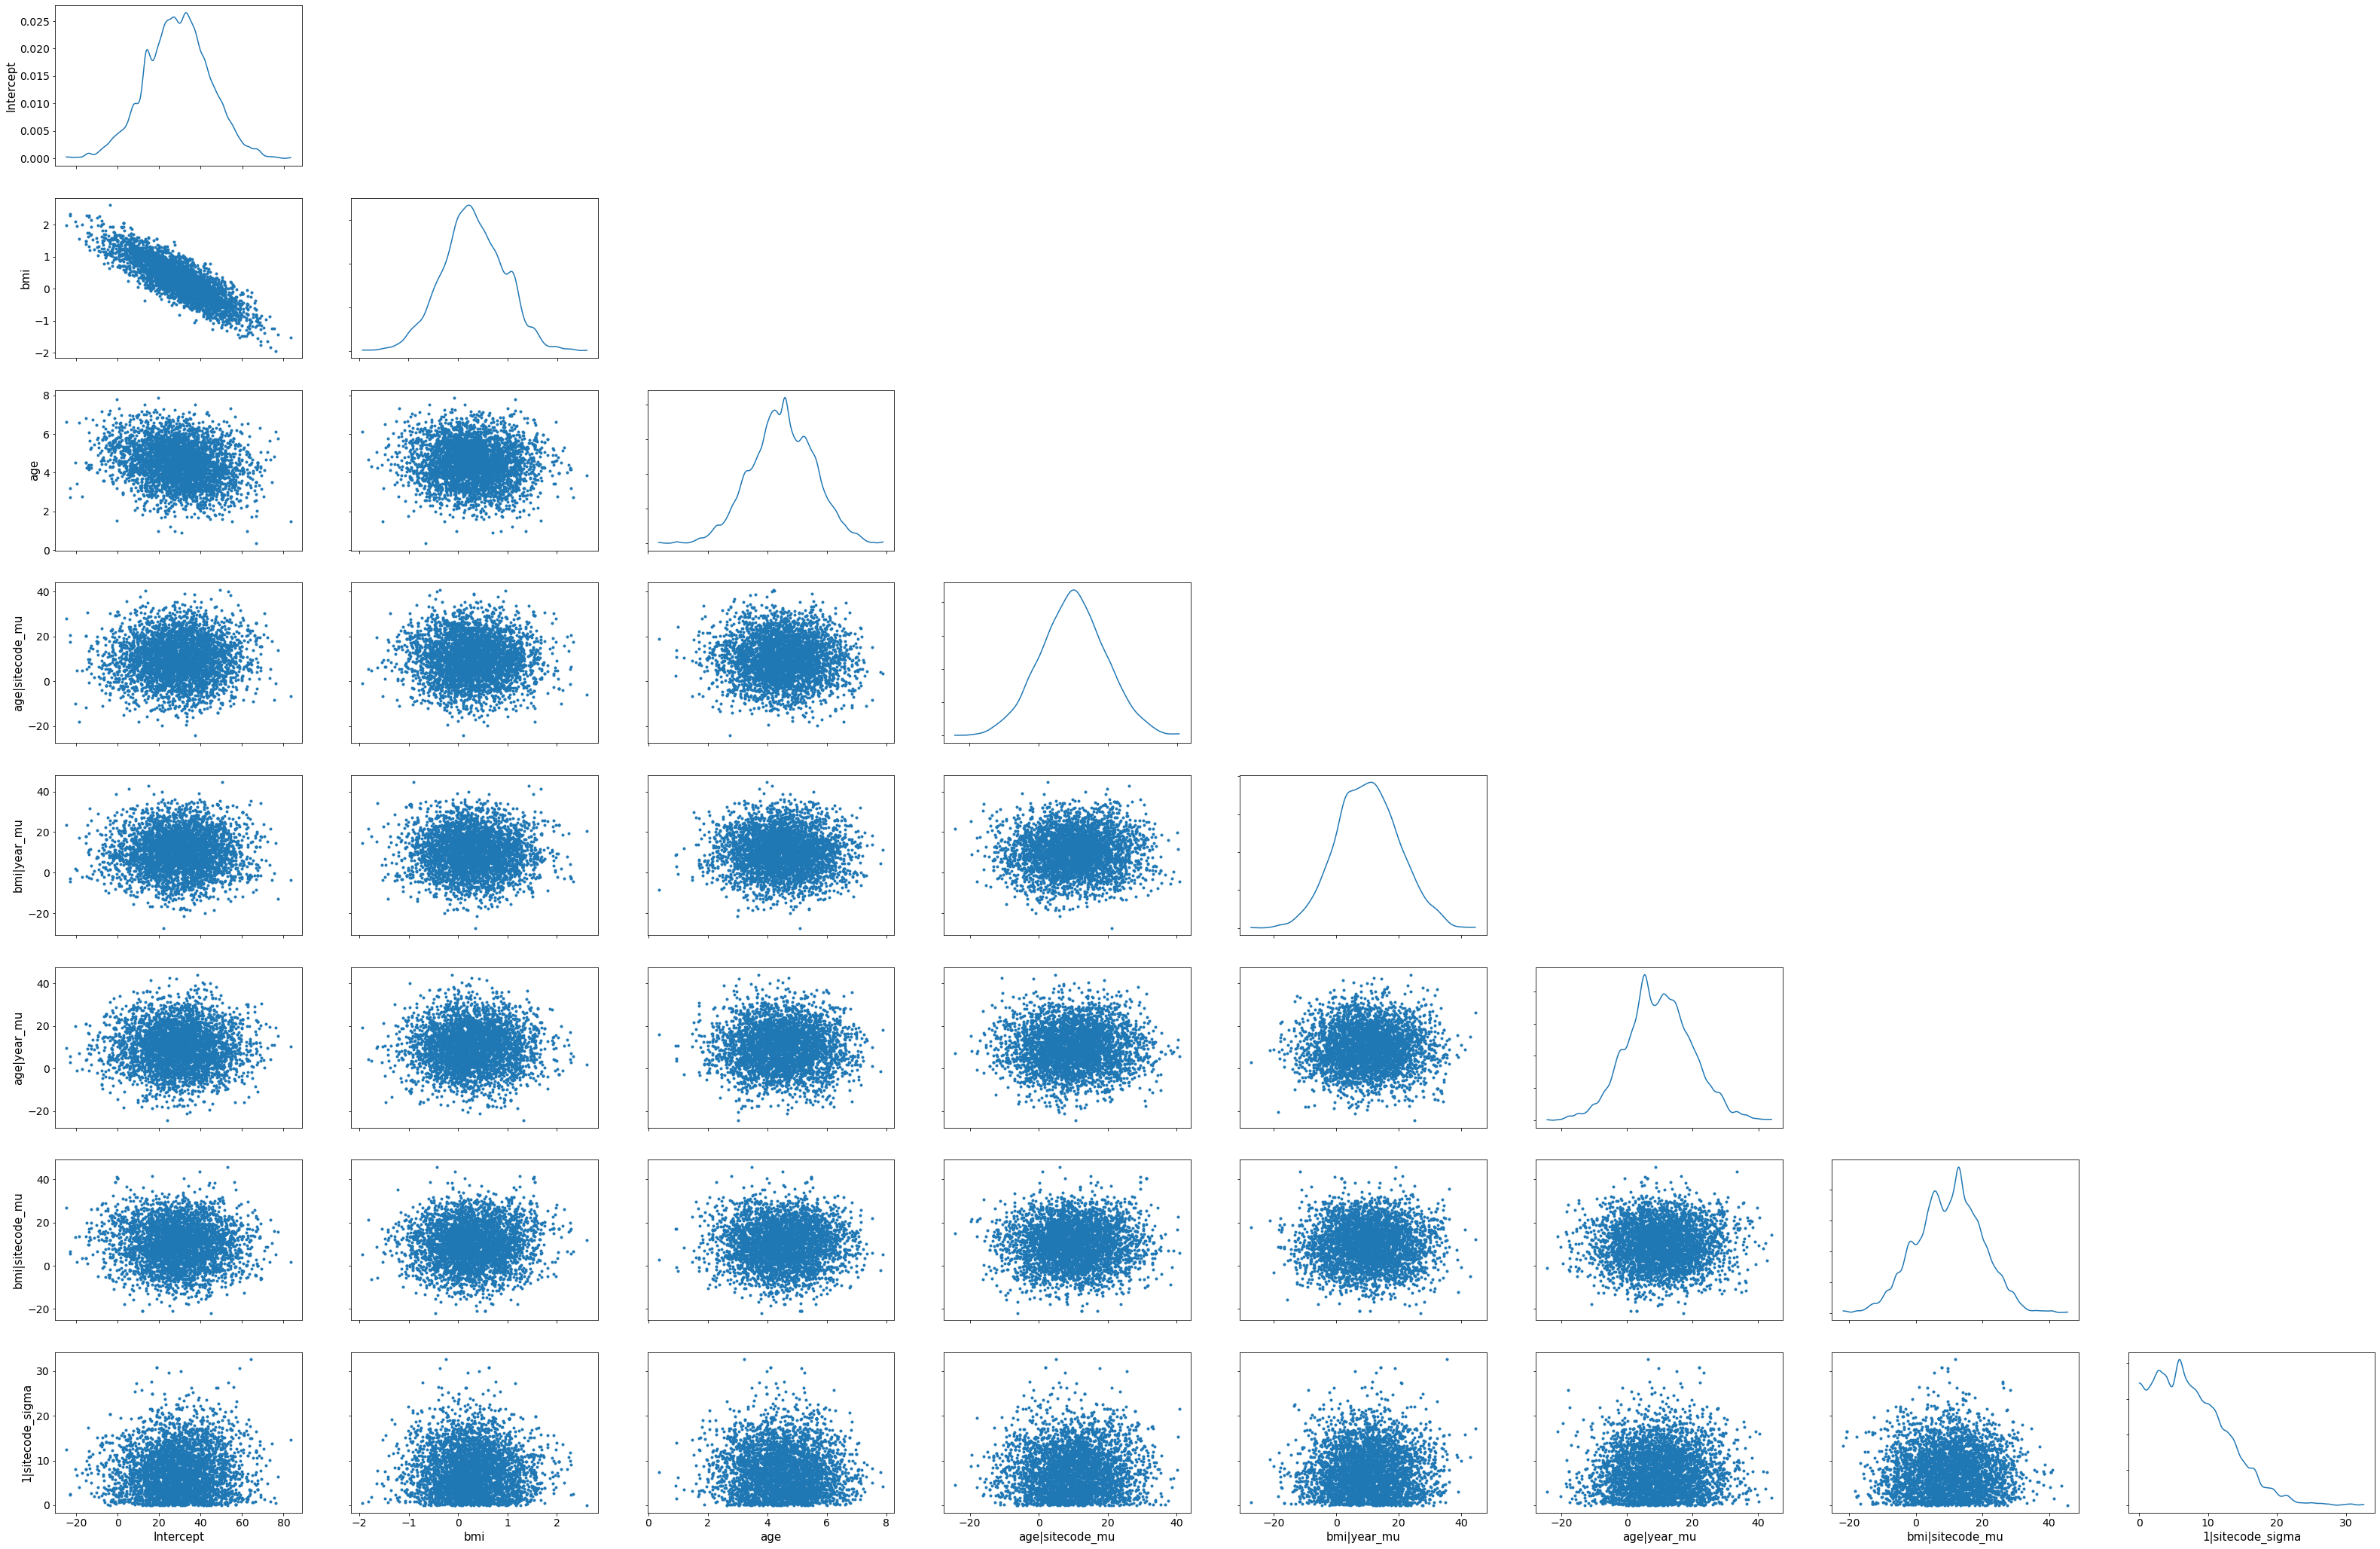

In [52]:
az.plot_pair(results, marginals=True);

In [53]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,28.911,15.351,-0.906,57.186,0.383,0.271,1596.0,1725.0,1.00
bmi,0.307,0.624,-1.006,1.340,0.020,0.016,1054.0,1324.0,1.00
age,4.500,1.048,2.541,6.465,0.023,0.016,2097.0,2036.0,1.00
age|sitecode_mu,9.957,9.437,-9.376,26.540,0.201,0.167,2196.0,2093.0,1.01
bmi|year_mu,10.076,9.927,-8.926,28.449,0.263,0.220,1440.0,931.0,1.01
...,...,...,...,...,...,...,...,...,...
bmi|sitecode[19],0.040,0.265,-0.487,0.588,0.006,0.005,1519.0,2380.0,1.00
bmi|sitecode[20],0.036,0.281,-0.533,0.585,0.006,0.005,1892.0,1499.0,1.00
bmi|sitecode[21],0.055,0.277,-0.506,0.603,0.006,0.005,2015.0,1899.0,1.00
bmi|sitecode[22],-0.070,0.309,-0.733,0.518,0.008,0.006,1665.0,1188.0,1.00


/Users/tangsw/opt/anaconda3/envs/umich/lib/python3.9/site-packages/arviz/plots/plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (101) in plot_posterior, generating only 40 plots
  warnings.warn(


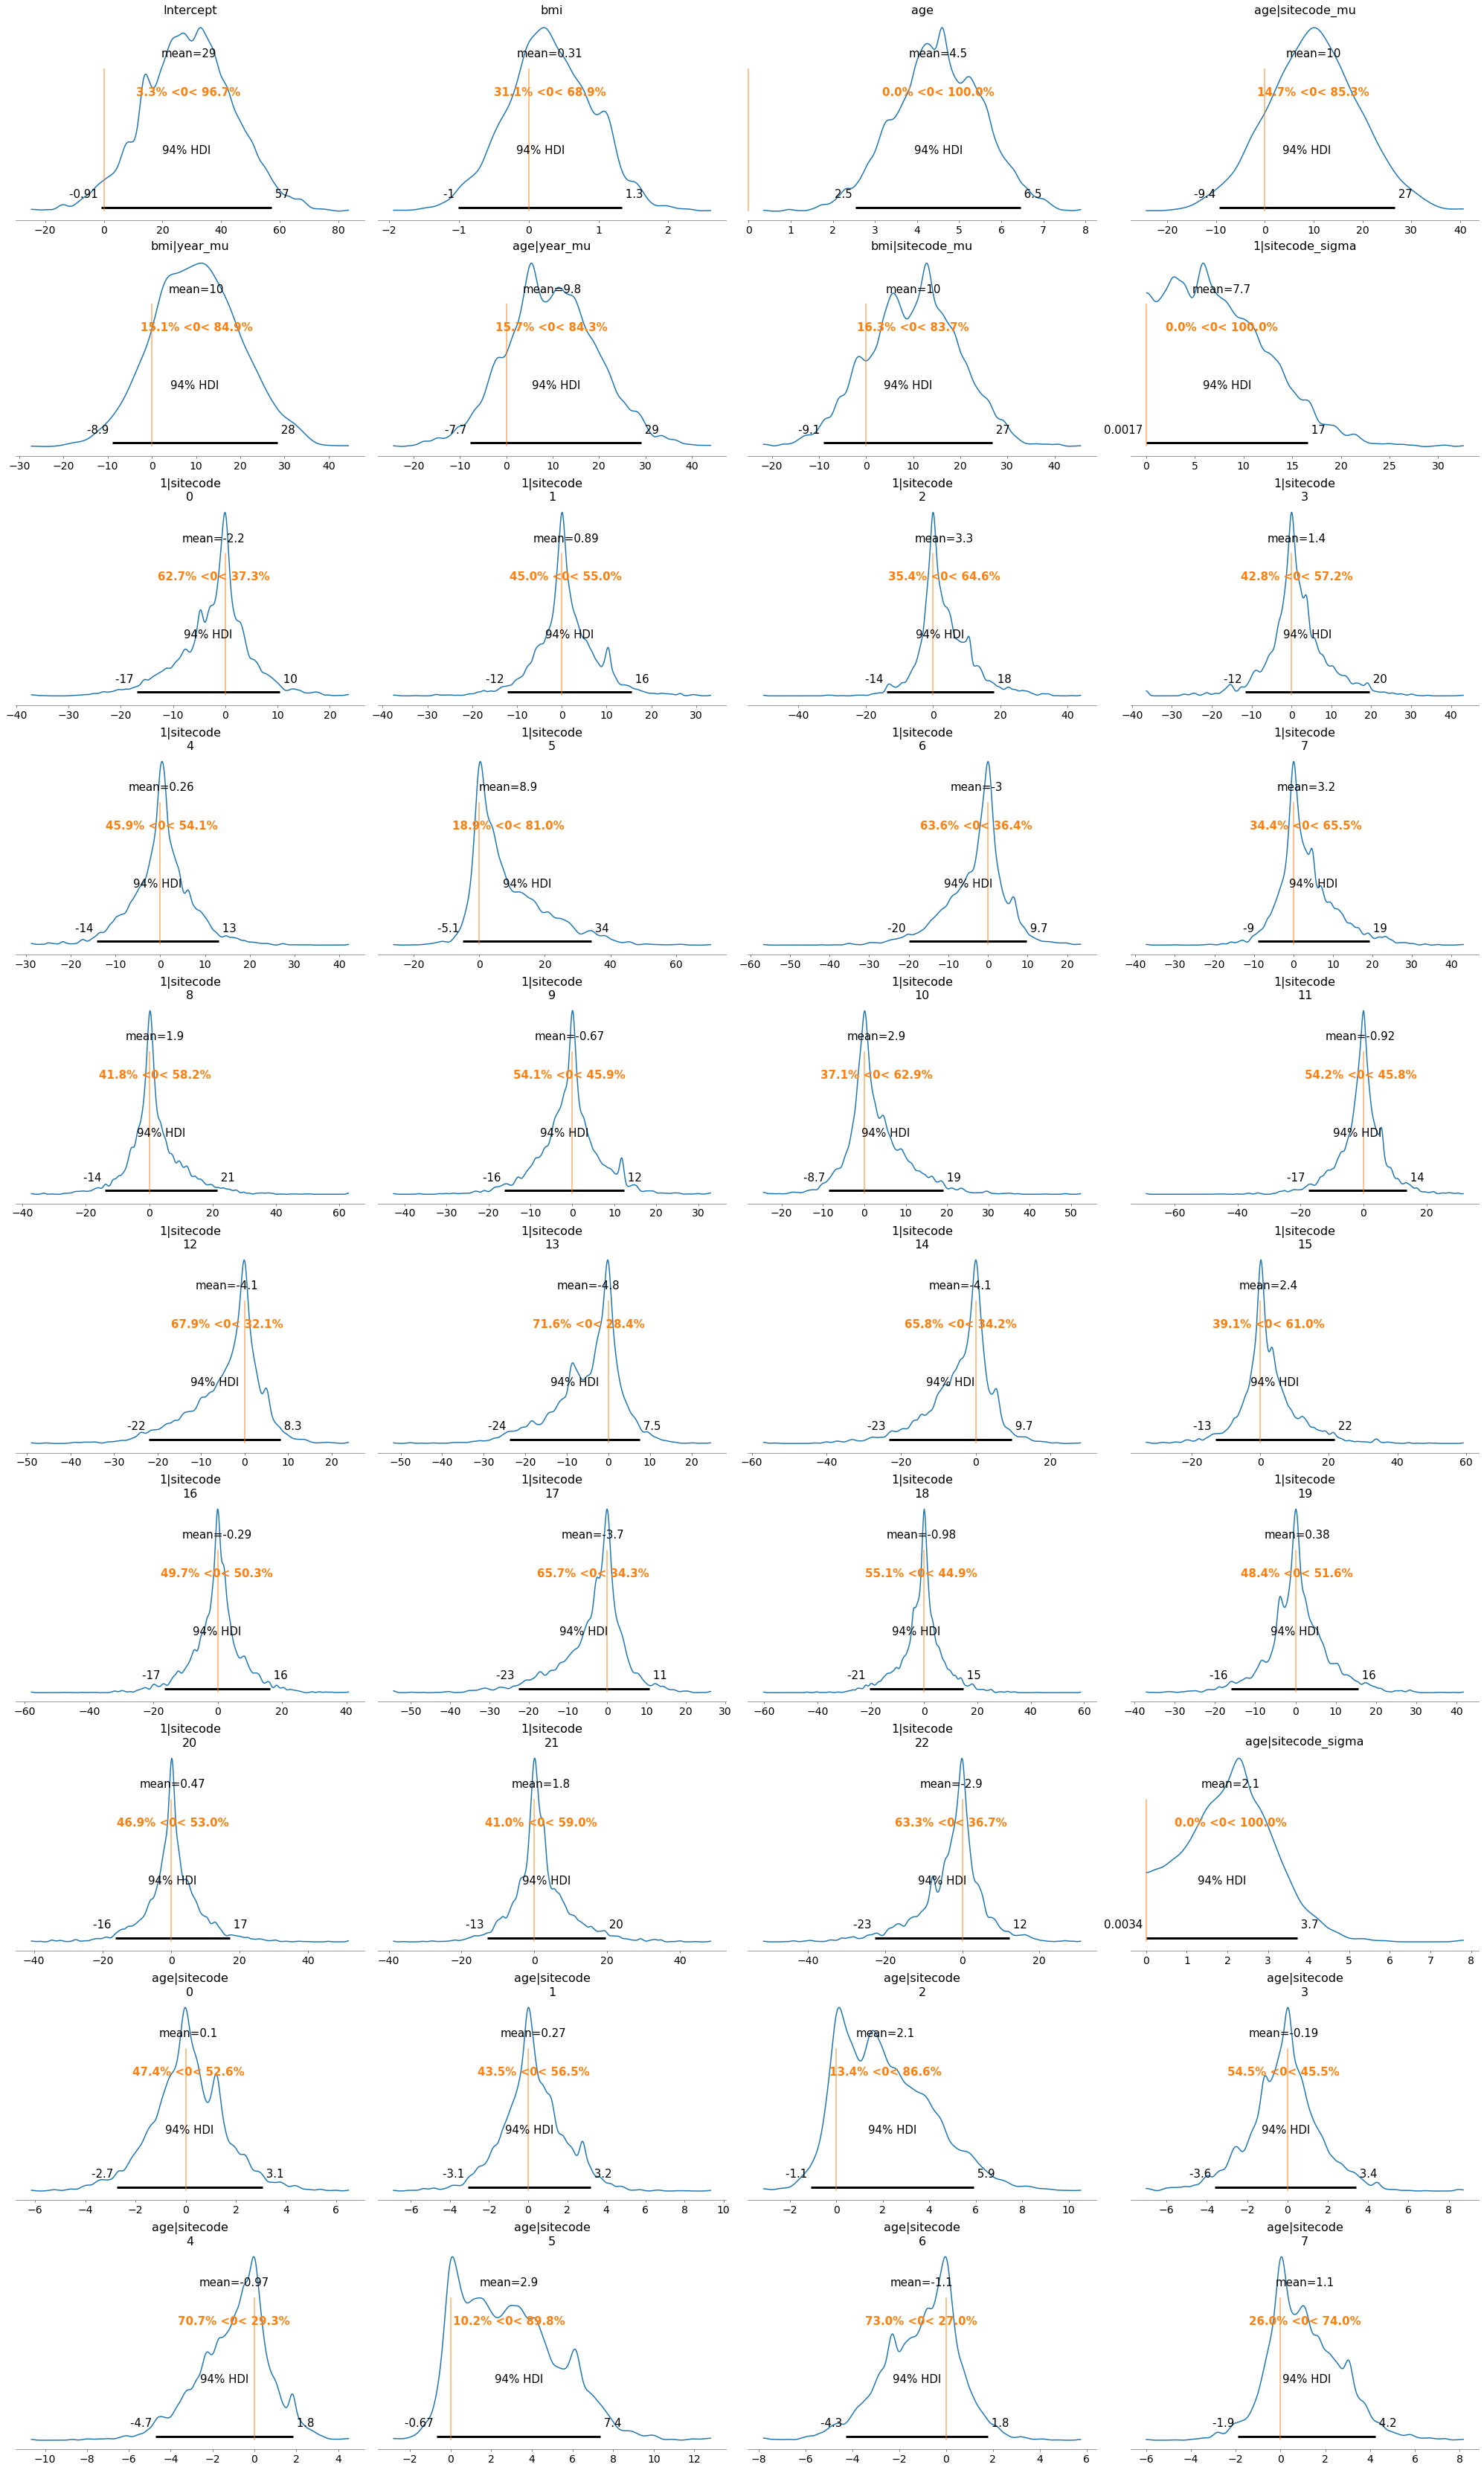

In [54]:
az.plot_posterior(results, ref_val=0);

# Prediction<a class="anchor" id="prediction"></a>
[back to top](#content)

In [ ]:
def test_result(model, )